# Solución de raspado web

## Paso 1: Instalar dependencias

In [1]:
pip install pandas requests

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Paso 2: Descargar HTML

In [1]:
import requests
import time

#url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
url = "https://finance.yahoo.com/quote/CL%3DF/history"
html_data = requests.get(url, time.sleep(10)).text

# If no information is extracted, then connect as anonymous
if "403 Forbidden" in html_data:
    headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
    request = requests.get(url, headers = headers)
    time.sleep(10)
    html_data = request.text

html_data

'<!DOCTYPE html>\n  <html lang="en-us"><head>\n  <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n      <meta charset="utf-8">\n      <title>Yahoo</title>\n      <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n      <style>\n  html {\n      height: 100%;\n  }\n  body {\n      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;\n      background-size: cover;\n      height: 100%;\n      text-align: center;\n      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;\n  }\n  table {\n      height: 100%;\n      width: 100%;\n      table-layout: fixed;\n      border-collapse: collapse;\n      border-spacing: 0;\n      border: none;\n  }\n  h1 {\n      font-size: 42px;\n      font-weight: 400;\n      color: #400090;\n  }\n  p {\n      color: #1A1A1A;\n  }\n  #message-1 {\n      font-weight: bold;\n      margin: 

## Paso 3: Transformar el HTML

In [2]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(html_data,"html.parser")
soup

<!DOCTYPE html>

<html lang="en-us"><head>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta charset="utf-8"/>
<title>Yahoo</title>
<meta content="width=device-width,initial-scale=1,minimal-ui" name="viewport"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<style>
  html {
      height: 100%;
  }
  body {
      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;
      background-size: cover;
      height: 100%;
      text-align: center;
      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;
  }
  table {
      height: 100%;
      width: 100%;
      table-layout: fixed;
      border-collapse: collapse;
      border-spacing: 0;
      border: none;
  }
  h1 {
      font-size: 42px;
      font-weight: 400;
      color: #400090;
  }
  p {
      color: #1A1A1A;
  }
  #message-1 {
      font-weight: bold;
      margin: 0;
  }
  #message-2 {
      display: inline-block;
      *display:

In [3]:
# Find all tables
tables = soup.find_all("table")
tables

[<table>
 <tbody><tr>
 <td>
 <img alt="Yahoo Logo" src="https://s.yimg.com/rz/p/yahoo_frontpage_en-US_s_f_p_205x58_frontpage.png"/>
 <h1 style="margin-top:20px;">Will be right back...</h1>
 <p id="message-1">Thank you for your patience.</p>
 <p id="message-2">Our engineers are working quickly to resolve the issue.</p>
 </td>
 </tr>
 </tbody></table>]

In [12]:
import pandas as pd

for index, table in enumerate(tables):
    if ("Tesla Quarterly Revenue" in str(table)):
        table_index = index
        break

# Create a DataFrame
tesla_revenue = pd.DataFrame(columns = ["Date", "Revenue"])
for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        Date = col[0].text
        Revenue = col[1].text.replace("$", "").replace(",", "")
        tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
            "Date": Date,
            "Revenue": Revenue
        }, index = [0])], ignore_index = True)

tesla_revenue.head()

NameError: name 'table_index' is not defined

## Paso 4: Procesar el marco de datos

In [ ]:
tesla_revenue = tesla_revenue[tesla_revenue["Revenue"] != ""]
tesla_revenue.head()

Date Revenue
0  2023-06-30   24927
1  2023-03-31   23329
2  2022-12-31   24318
3  2022-09-30   21454
4  2022-06-30   16934

## Paso 5: almacenar los datos en sqlite

In [ ]:
import sqlite3

connection = sqlite3.connect("Tesla.db")
connection

In [ ]:
cursor = connection.cursor()
cursor.execute("""CREATE TABLE revenue (Date, Revenue)""")

In [ ]:
tesla_tuples = list(tesla_revenue.to_records(index = False))
tesla_tuples[:5]

[('2023-06-30', '24927'),
 ('2023-03-31', '23329'),
 ('2022-12-31', '24318'),
 ('2022-09-30', '21454'),
 ('2022-06-30', '16934')]

In [ ]:
cursor.executemany("INSERT INTO revenue VALUES (?,?)", tesla_tuples)
connection.commit()

In [ ]:
# Check the data from the database
for row in cursor.execute("SELECT * FROM revenue"):
    print(row)

('2023-06-30', '24927')
('2023-03-31', '23329')
('2022-12-31', '24318')
('2022-09-30', '21454')
('2022-06-30', '16934')
('2022-03-31', '18756')
('2021-12-31', '17719')
('2021-09-30', '13757')
('2021-06-30', '11958')
('2021-03-31', '10389')
('2020-12-31', '10744')
('2020-09-30', '8771')
('2020-06-30', '6036')
('2020-03-31', '5985')
('2019-12-31', '7384')
('2019-09-30', '6303')
('2019-06-30', '6350')
('2019-03-31', '4541')
('2018-12-31', '7226')
('2018-09-30', '6824')
('2018-06-30', '4002')
('2018-03-31', '3409')
('2017-12-31', '3288')
('2017-09-30', '2985')
('2017-06-30', '2790')
('2017-03-31', '2696')
('2016-12-31', '2285')
('2016-09-30', '2298')
('2016-06-30', '1270')
('2016-03-31', '1147')
('2015-12-31', '1214')
('2015-09-30', '937')
('2015-06-30', '955')
('2015-03-31', '940')
('2014-12-31', '957')
('2014-09-30', '852')
('2014-06-30', '769')
('2014-03-31', '621')
('2013-12-31', '615')
('2013-09-30', '431')
('2013-06-30', '405')
('2013-03-31', '562')
('2012-12-31', '306')
('2012-09-30

## Paso 6: Visualiza los datos

### Visualización de series de tiempo

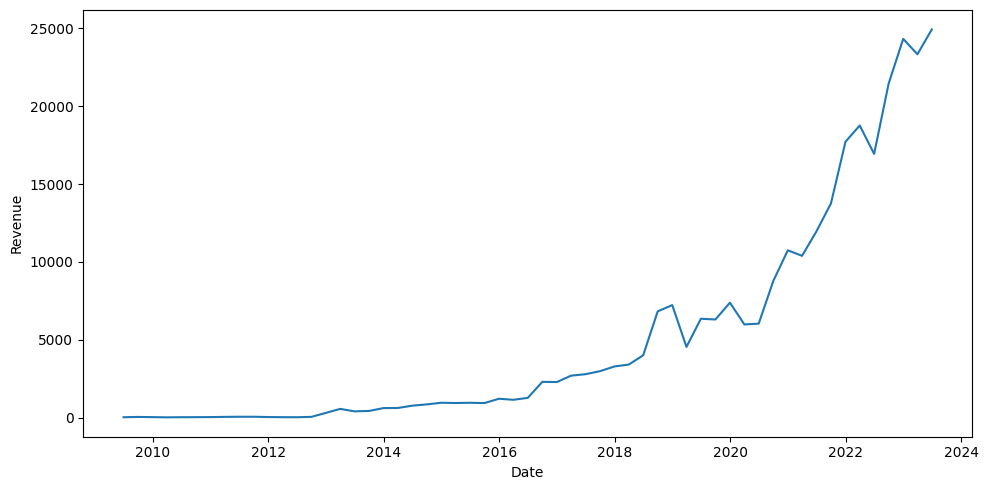

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype('int')
sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

### Beneficio bruto anual

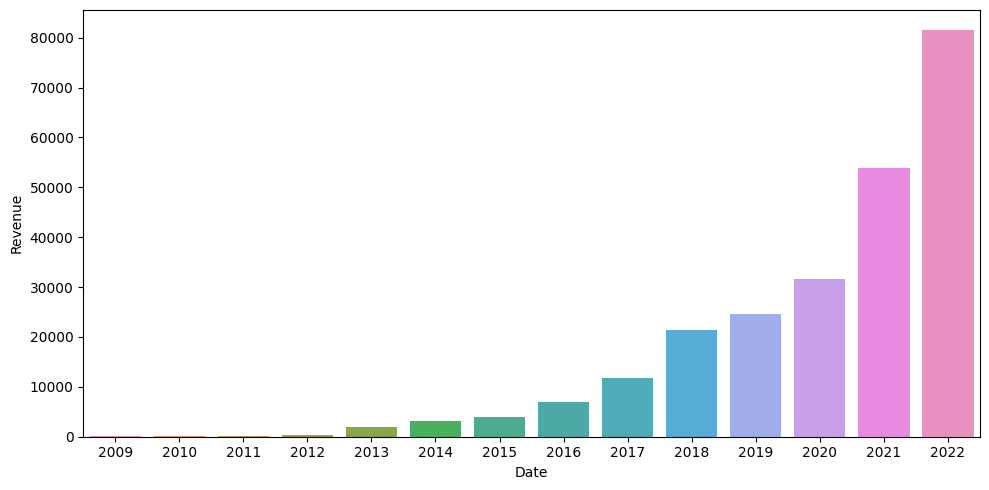

In [ ]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue_yearly = tesla_revenue.groupby(tesla_revenue["Date"].dt.year).sum().reset_index()

sns.barplot(data = tesla_revenue_yearly[tesla_revenue_yearly["Date"] < 2023], x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

### Beneficio bruto mensual

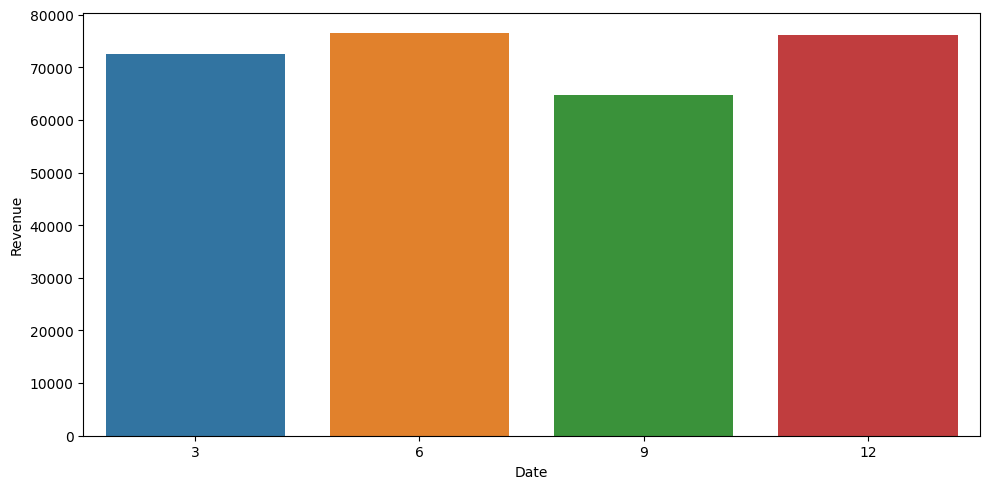

In [ ]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue_monthly = tesla_revenue.groupby(tesla_revenue["Date"].dt.month).sum().reset_index()

sns.barplot(data = tesla_revenue_monthly, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()